# A / B för andelar

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
np.random.seed(42)  # gör slump repeterbar

# 1) Stickprovsstorlekar
n_A = 150
n_B = 160

# 2) "Sanna" andelar i vår fiktiva population (endast för simulering)
true_p_A = 0.26
true_p_B = 0.32

# 3) Skapa 0/1-utfall: 1 = "lyckades", 0 = "inte"
outcomes_A = np.random.binomial(n=1, p=true_p_A, size=n_A)
outcomes_B = np.random.binomial(n=1, p=true_p_B, size=n_B)

# 4) Bygg DataFrame
dates = pd.date_range("2025-10-01", periods=n_A + n_B, freq="D")
df = pd.DataFrame({
    "group": ["A"]*n_A + ["B"]*n_B,
    "outcome": np.concatenate([outcomes_A, outcomes_B]),
    "date": dates[:n_A + n_B]
})

# 5) Lägg in "stök" så städningen blir på riktigt
df.loc[5, "outcome"] = np.nan         # saknat värde
df.loc[80, "outcome"] = np.nan        # saknat värde
dup_row = df.iloc[10].copy()          # dubblett
df = pd.concat([df, dup_row.to_frame().T], ignore_index=True)
df.loc[20, "outcome"] = 2             # ogiltigt (inte 0/1)
df.loc[190, "outcome"] = -1           # ogiltigt (inte 0/1)

# 6) Spara som CSV
csv_path = "ab_proportion_data.csv"
df.to_csv(csv_path, index=False)

In [4]:
df = pd.read_csv("ab_proportion_data.csv", parse_dates=["date"])

display(df.head())
df.info()
df.select_dtypes(include="number").describe()

,group,outcome,date
0,A,0.0,2025-10-01
1,A,1.0,2025-10-02
2,A,0.0,2025-10-03
3,A,0.0,2025-10-04
4,A,0.0,2025-10-05


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   group    311 non-null    object        
 1   outcome  309 non-null    float64       
 2   date     311 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 7.4+ KB


,outcome
count,309.000000
mean,0.294498
std,0.470564
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [5]:
nan_count = df["outcome"].isna().sum()
duplicated_count = df.duplicated().sum()

invalid_mask = ~df["outcome"].isin([0, 1]) & ~df["outcome"].isna()
invalid_count = invalid_mask.sum()


nan_count, duplicated_count, invalid_count

(np.int64(2), np.int64(1), np.int64(2))

In [6]:
df_clean = df.drop_duplicates()
df_clean = df_clean.dropna(subset=["outcome"])
df_clean = df_clean[df_clean["outcome"].isin([0, 1])]

group_sizes = df_clean.groupby("group")["outcome"].size()
assert (group_sizes >= 20).all(), "För få observationer i någon grupp!"

df_clean.shape, group_sizes.to_dict(), df_clean["outcome"].value_counts()

((306, 3),
 {'A': 147, 'B': 159},
 outcome
 0.0    216
 1.0     90
 Name: count, dtype: int64)

In [7]:
summary = df_clean.groupby("group")["outcome"].agg(
    observations="count",
    successes="sum",
    proportion="mean"
).reset_index()

z_crit = stats.norm.ppf(0.975)                                # mitt ± 1.96 * osäkerhet
ci_low, ci_high = [], []

for _, row in summary.iterrows():
    n = row["observations"]
    p = row["proportion"]
    se = np.sqrt(p*(1-p)/n)
    ci_low.append(p - z_crit * se)
    ci_high.append(p + z_crit * se)

summary["ci_low"] = ci_low
summary["ci_high"] = ci_high
summary

,group,observations,successes,proportion,ci_low,ci_high
0,A,147,37.0,0.251701,0.181544,0.321857
1,B,159,53.0,0.333333,0.260060,0.406606


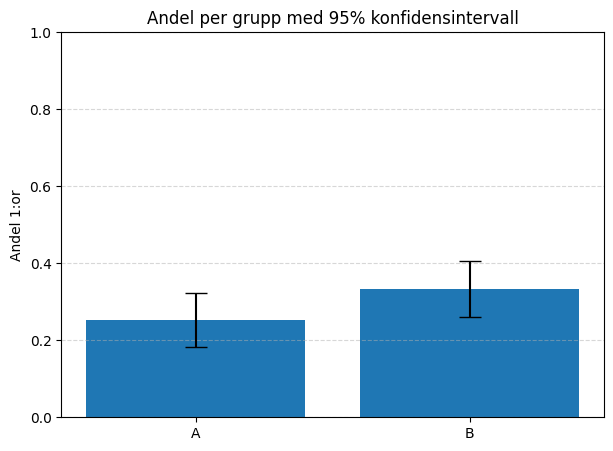

In [8]:
fig, ax = plt.subplots(figsize=(7, 5))
x = np.arange(len(summary))

ax.bar(
    x,
    summary["proportion"],
    yerr=[summary["proportion"] - summary["ci_low"],
          summary["ci_high"] - summary["proportion"]],
          capsize=8
)

ax.set_xticks(x)
ax.set_xticklabels(summary["group"])
ax.set_ylim(0, 1)
ax.set_ylabel("Andel 1:or")
ax.set_title("Andel per grupp med 95% konfidensintervall")
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

- H0 (nollhypotes): Det finns ingen verklig skillnad i andel mellan B och A i populationen
- H1 (tvåsidig): Det finns en skillnad (okänt om B>A eller B<A).
- H1 (ensidig, bestäms i förväg): B har högre andel än A

In [9]:
n_A = int(summary.loc[summary["group"] == "A", "observations"].values[0])
n_B = int(summary.loc[summary["group"] == "B", "observations"].values[0])
x_A = int(summary.loc[summary["group"] == "A", "successes"].values[0])
x_B = int(summary.loc[summary["group"] == "B", "successes"].values[0])

p_A = x_A / n_A
p_B = x_B / n_B
diff = p_B - p_A

p_pooled = (x_A + x_B) / (n_A + n_B)

se_pooled = np.sqrt(p_pooled * (1 - p_pooled) * (1 / n_A + 1 / n_B))

z_stat = diff / se_pooled

p_two_sided = 2 * (1 - stats.norm.cdf(abs(z_stat)))
p_one_sided_B_greater = 1 - stats.norm.cdf(z_stat)

z_stat, p_two_sided, p_one_sided_B_greater, diff

(np.float64(1.5657907523906596),
 np.float64(0.11739761188666864),
 np.float64(0.05869880594333432),
 0.08163265306122447)

In [10]:
se_unpooled = np.sqrt(p_A * (1 - p_A) / n_A + p_B * (1 - p_B) / n_B)

z_crit = stats.norm.ppf(0.975)

ci_low = diff - z_crit * se_unpooled
ci_high = diff + z_crit * se_unpooled
(ci_low, ci_high), diff

((np.float64(-0.019811326257603165), np.float64(0.18307663238005212)),
 0.08163265306122447)

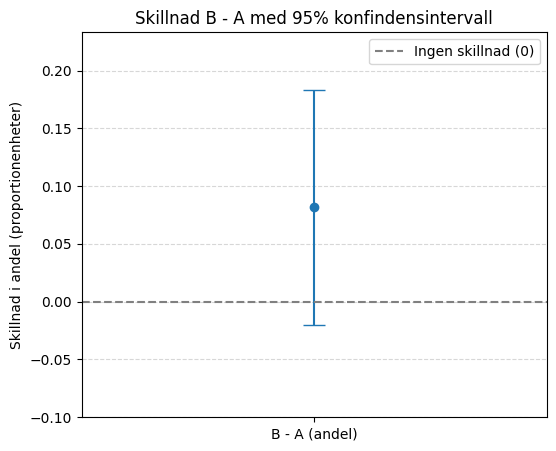

In [11]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.errorbar([0], [diff], yerr=[[diff - ci_low], [ci_high - diff]], fmt="o", capsize=8)
ax.axhline(0, linestyle="--", color="gray", label="Ingen skillnad (0)")
ax.set_xticks([0])
ax.set_xticklabels(["B - A (andel)"])
ax.set_ylim(min(-0.1, ci_low - 0.05), max(0.1, ci_high + 0.05))
ax.set_ylabel("Skillnad i andel (proportionenheter)")
ax.set_title("Skillnad B - A med 95% konfindensintervall")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

In [12]:
absolute_pp = diff * 100

relative_lift = (p_B / p_A - 1) * 100 if p_A > 0 else np.inf

absolute_pp, relative_lift

(8.163265306122447, 32.432432432432435)

In [13]:
def pct(x): return f"{x * 100:.1f}%"

conclusion = f"""
Andel A = {pct(p_A)}, Andel B = {pct(p_B)}.
Skillnaden (B - A) = {absolute_pp:.1f} procentenheter.
95% CI för skillnaden: [{ci_low*100:.1f}, {ci_high*100:.1f}] pp.
Tvåsidigt p-värde = {p_two_sided:.4f}.
Ensidigt p-värde (B > A) = {p_one_sided_B_greater:.4f}.
Relativ lift ≈ {relative_lift:.1f}%.
"""

print(conclusion)


Andel A = 25.2%, Andel B = 33.3%.
Skillnaden (B - A) = 8.2 procentenheter.
95% CI för skillnaden: [-2.0, 18.3] pp.
Tvåsidigt p-värde = 0.1174.
Ensidigt p-värde (B > A) = 0.0587.
Relativ lift ≈ 32.4%.

